# Stochastic Differential Equations
Here, We use simplest approach of difference equations to define SDE's instead of Stochastic Analysis.
### Defining SDEs as the limit of Difference Equations
We define solution of the `Stochastic differential equation (SDE)`
$$ d Y_t = a(Y_t,t) \, dt + b(Y_t,t) \, dW_t, \quad \text{given } y_0$$
for coefficient functions $a,b:{\mathbb R}^2\to {\mathbb R}$ to be the limit of the *Euler-Maruyama scheme*
$$ \delta Y^{\cal T}_t = a(Y^{\cal T}_t, t) \, \delta t + b(Y^{\cal T}_t, t) \, \delta W^{\cal T}_t, \quad \text{given } Y^{\cal T}_0 = Y_0$$
as $\delta t \to 0$ where
$$
\begin{split}
\delta Y^{\cal T}_t&:=Y^{\cal T}_{t+\delta t}-Y^{\cal T}_t \\
\delta W^{\cal T}_t&:=W_{t+\delta t}-W_t \\
\text{The grid } {\cal T}&:=\{0,\delta t, 2 \delta t, \ldots \}
\end{split}
$$
The SDE itself should be thought of as just a convenient shorthand for the difference equation. We haven't defined what $d Y_t$ is at all. Expanding out the terms $\delta Y^{\cal T}_t$ and $\delta W^{\cal T}_t$ we get a more explicit difference equation:    
$$
\boxed{
Y^{\cal T}_{t+\delta t}=Y^{\cal T}_t + a(Y^{\cal T}_t,t)\,\delta t + b(Y^{\cal T}_t,t)(W_{t+\delta t}-W_t)}
$$
We've only defined $Y^{\cal T}_t$ for points $t \in {\cal T}$ but we can define $Y^{\cal T}_t$ for points outside
the grid ${\cal T}$ using linear interpolation. When taking the limit of random variables, there are various choices. There is the limit in *expectation*, the limit in *probability*, the *almost-sure* limit and the limit in $L^p$ for $p\geq 1$. Here, we'll take the limit in probability. The conditions under which this limit exists is if we assume the coefficient functions $a(y,t)$ and $b(y,t)$ are smooth then the limit will exist up to some random time $\tau$. We write $Y_t=\infty$ for all times $t\geq\tau$.

### Continuous time Geometric Brownian motion
Define a process $S_t$ using the difference equation $$ d S_t = \mu S_t \, dt + \sigma S_t \, dW_t $$
with $S_0$ given and $\mu$, $\sigma$ constants.

Let us simulate $S^{\cal T}_t$ given a pair of vectors $(W,t)$ representing a sample of a Wiener process on the grid ${\cal T}$.
Before generating values for $S^{\cal T}_t$, lets write a code to generate Wiener process using Wiener's construction.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,7]

def one_step_wiener(T):
    """Generate a discrete time Wiener process on [0,T]
       with one step"""
    W1 = np.random.randn(1)*np.sqrt(T)
    return np.array([0,W1[0]]),np.array([0,T])

def riffle( v1, v2 ):
    """Take two vectors and alternate their entries
       to create a new vector"""    
    assert len(v1)==len(v2)+1
    ret = np.zeros(2*len(v1)-1)
    for i in range(0,len(v1)):
        ret[2*i] = v1[i]
    for i in range(0,len(v2)):
        ret[2*i+1] = v2[i]    
    return ret

def test_riffle():
    v1 = np.array([0,1,2])
    v2 = np.array([0.5,1.5])
    v = riffle(v1,v2)
    expected = np.array([0,0.5,1,1.5,2])
    assert np.linalg.norm(v-expected) < 0.001

def compute_halfway_times(t):
    """Compute the times halfway between those in the vector t"""
    all_but_last=t[0:-1]
    all_but_first=t[1:]
    return 0.5*(all_but_last + all_but_first)

def test_compute_halfway_times():
    t = np.array([0,1/4,1/2,3/4,1])
    halfway_times = compute_halfway_times(t)
    expected = np.array([1/8,3/8,5/8,7/8])
    for i in range(0,len(expected)):
        assert abs(halfway_times[i]-expected[i])<0.001    

def simulate_intermediate_values(W, t):    
    """Simulate values of a Wiener process at the halfway times of t given the values at t"""
    delta_t = t[1:]-t[0:-1]
    halfway_values = 0.5*(W[1:]+W[0:-1])
    eps = np.random.randn(len(W)-1)
    return halfway_values + 0.5*np.sqrt(delta_t)*eps

def test_simulate_intermediate_values():
    np.random.seed(1) # Always use the same "random" numbers
    n_samples = 10000
    d1 = np.zeros(n_samples)
    d2 = np.zeros(n_samples)
    for i in range(0,n_samples):
        W,t = one_step_wiener(1)
        intermediate = simulate_intermediate_values(W,t)
        W_1 = W[1]
        W_0 = W[0]
        W_half = intermediate[0]
        d1[i] = W_half-W_0
        d2[i] = W_1-W_half
    cov = np.cov(d1,d2)
    expected = np.array([[0.5,0],[0,0.5]])
    assert np.linalg.norm(cov-expected)<0.05

def wiener_interpolate( W, t ):
    """Take a discrete time Wiener process at times given
       by the vector t and generate an interpolated process at
       the halfway times"""
    halfway_times = compute_halfway_times(t)
    halfway_values = simulate_intermediate_values(W, t)
    new_W = riffle(W,halfway_values)
    new_t = riffle(t,halfway_times)
    return new_W, new_t

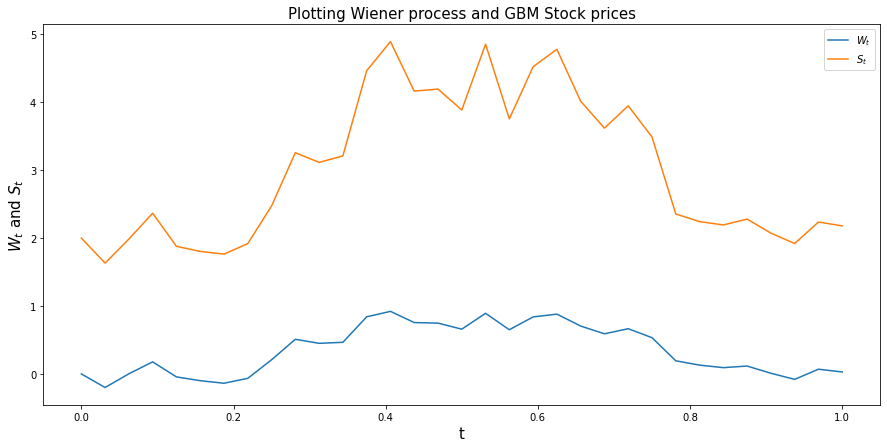

In [4]:
def simulate_S( S0, mu, sigma, W, t ):
    delta_W = W[1:]-W[0:-1]
    delta_t = t[1:]-t[0:-1]
    S = np.zeros(len(W))
    S[0] = S0
    for i in range(0,len(S)-1):
        S[i+1] = S[i] + S[i]*mu*delta_t[i] + S[i]*sigma*delta_W[i]
    return S

# Generating a Wiener process.
W, t = one_step_wiener(1)
for i in range(0,5):
    W, t = wiener_interpolate(W,t)

# Computing values for S using Euler-Maruyama Approximation.   
S0 = 2
mu = 0.5
sigma = 1
S = simulate_S(S0,mu,sigma,W,t)

# Plot the results.
ax = plt.gca()
ax.plot(t,W,label='$W_t$');
ax.plot(t,S,label='$S_t$');
plt.xlabel('t',fontsize = 15)
plt.ylabel('$W_t$ and $S_t$',fontsize = 15)
plt.title('Plotting Wiener process and GBM Stock prices', fontsize = 15)
ax.legend(); 

Note: $W_t$ is the driving process in this SDE. You can see how fluctuations in $W_t$ drive corresponding fluctuations in $S_t$. There is an analytic solution to this particular SDE. In the limit as $\delta t \to 0$ tends to zero this converges to
$$
\boxed{
S_t =  e^{(\mu - \frac{1}{2}\sigma^2) t  + \sigma W_t}}
$$
Lets compare the two results using `Euler-Maruyama Approximation` and `Analytic Formula` and see if the two values converge as we keep refining $W_t$ using Wiener's construction.

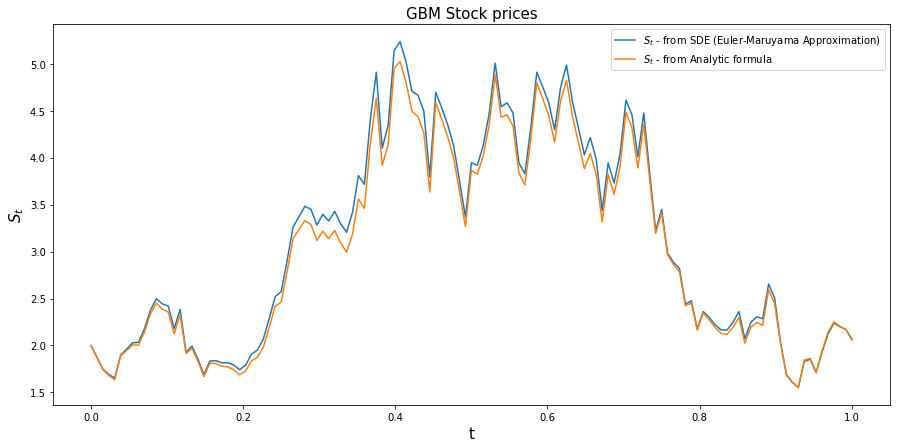

In [6]:
# Run this cell repeatedly to see the convergence of two graphs as we keep refining W using Wiener construction.
W, t = wiener_interpolate(W,t)
S = simulate_S(S0,mu,sigma,W,t)
actual_S = S0 *np.exp((mu-0.5*sigma**2)*t + sigma*W)  # Computing S using Analytic Formula.

ax = plt.gca()
ax.plot(t,S,label='$S_t$ - from SDE (Euler-Maruyama Approximation)');
ax.plot(t,actual_S,label='$S_t$ - from Analytic formula');
plt.xlabel('t',fontsize = 15)
plt.ylabel('$S_t$',fontsize = 15)
plt.title('GBM Stock prices', fontsize = 15)
ax.legend(); 

Lets plot a fan diagram of the Euler Maruyama approximation to the SDE
$$d S_t = \mu S_t \, d t + \sigma S_t d W_t$$
when $S_0=3$, $\mu=0.5$, $\sigma=1$ on the interval $[0,1]$ using $1024$ steps.

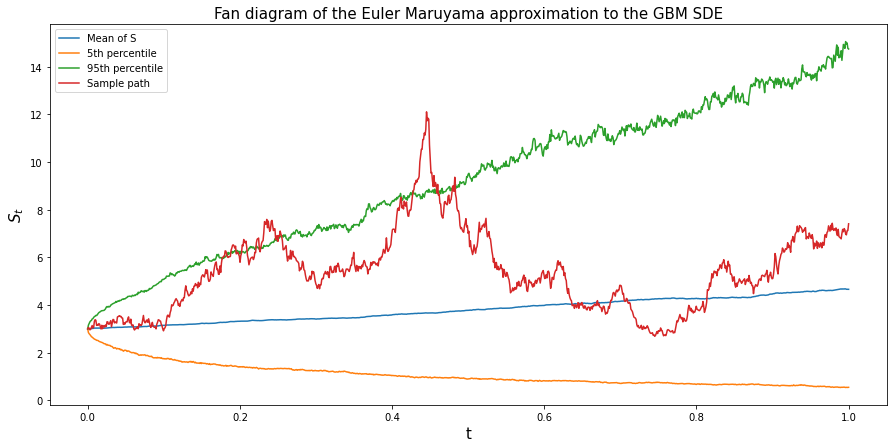

In [7]:
S0 = 3
mu = 0.5
sigma = 1
N = 1024 # Number of steps.
n_simulations = 1000 # Can increase this value for a smoother graph.
S = np.zeros((n_simulations,N+1))
for i in range(0,n_simulations):
    # Generate a Brownian motion/Wiener process.
    W, t = one_step_wiener(1)  # Generate a discrete time Wiener process on [0,1] with one step.
    for j in range(0,10):
        W, t = wiener_interpolate(W,t)
    S[i,:] = simulate_S(S0,mu,sigma,W,t)
    
def fan_plot( t, S, varName='S', sde = 'GBM'):
    ax = plt.gca()
    ax.plot(t, np.mean(S,axis=0),label='Mean of {}'.format(varName))
    ax.plot(t, np.percentile(S,5,axis=0),label='5th percentile' )
    ax.plot(t, np.percentile(S,95,axis=0),label='95th percentile' )
    ax.plot(t, S[0,:],label='Sample path' )
    plt.xlabel('t',fontsize = 15)
    plt.ylabel('${}_t$'.format(varName),fontsize = 15)
    plt.title('Fan diagram of the Euler Maruyama approximation to the {} SDE'.format(sde), fontsize = 15)
    ax.legend()
    
fan_plot(t,S)

### Constant Coefficient SDE

The Constant coefficient SDE is defined as:
$$
d X_t = a \, dt + b \, d W_t
$$
where $a$ and $b$ are constants.

The solution of this SDE is
$$
X_t = X_0 + a t + b W_t.
$$

$X_t$ in this case satisfies *continuous time Brownian motion*.

If $X^{\cal T}_t$ is the Euler-Maruyama approximation to the solution of the above SDE then
$$
X^{\cal T}_t = X_0 + a t + b W_t.
$$
Using Euler-Maruyama approximation:
$$X^{\cal T}_{t+\delta t}:= X^{\cal T}_{t} + a \delta t + b (W_{t+\delta t} - W_t)$$
If we assume as induction hypothesis that
$$
X^{\cal T}_t = X_0 + a t + b W_t.
$$
we find
$$
\begin{split}
X^{\cal T}_{t+\delta t}&= X_0 + a t + b W_t + a \delta t + b (W_{t+\delta t} - W_t)
&= X_0 + a(t + \delta t) + b W_{t+\delta t}.
\end{split}
$$
In the limit as $\delta t \to 0$ tends to zero and by induction this converges to $$
X_t = X_0 + a t + b W_t.
$$

### Ornstein–Uhlenbeck Process
The Ornstein–Uhlenbeck process $X_t$ is defined by the following SDE:
$$d X_t = \theta(\mu-X_t) \, d t + \sigma \, d W_t$$
for constants $\theta >0$, $\mu$ and $\sigma>0$. The value of $\mu$ is called the mean-reversion
level, $\theta$ is called the speed of mean-reversion and $\sigma$ is the constant volatility. As usual $W_t$ is the Wiener process(Brownian motion).

Lets plot a fan diagram of this process when $X_0=3$, $\theta=1$, $\mu=2$ and $\sigma=1$.

In [8]:
def simulate_X( X0, theta, mu, sigma, W, t ):
    delta_W = W[1:]-W[0:-1]
    delta_t = t[1:]-t[0:-1]
    X = np.zeros(len(W))
    X[0]=X0
    for i in range(0,len(W)-1):
        X[i+1] = X[i] + theta*(mu-X[i])*delta_t[i] + sigma*delta_W[i]
    return X

def ornstein_uhlenbeck_fan_plot( X0, theta, mu, sigma, T=10, n_simulations=1000):
    N = 1024 # Number of steps.
    X = np.zeros((n_simulations,N+1))
    for i in range(0,n_simulations):
        # Generate a Brownian motion
        W, t = one_step_wiener(T)
        for j in range(0,10):
            W, t = wiener_interpolate(W,t)
        X[i,:] = simulate_X(X0,theta,mu,sigma,W,t)
    fan_plot(t,X,'X','Ornstein–Uhlenbeck')

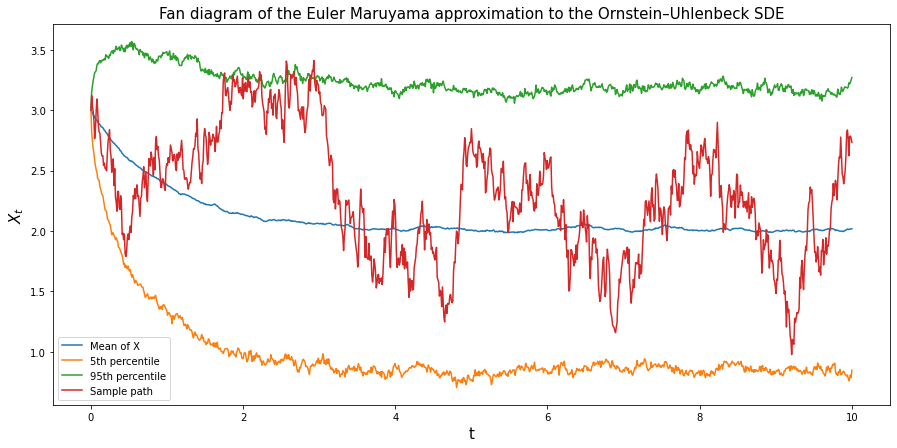

In [9]:
# This plot shows that the process tends to a long term mean of mu = 2.0
X0=3;theta=1;mu=2;sigma=1;
ornstein_uhlenbeck_fan_plot(X0, theta, mu, sigma)

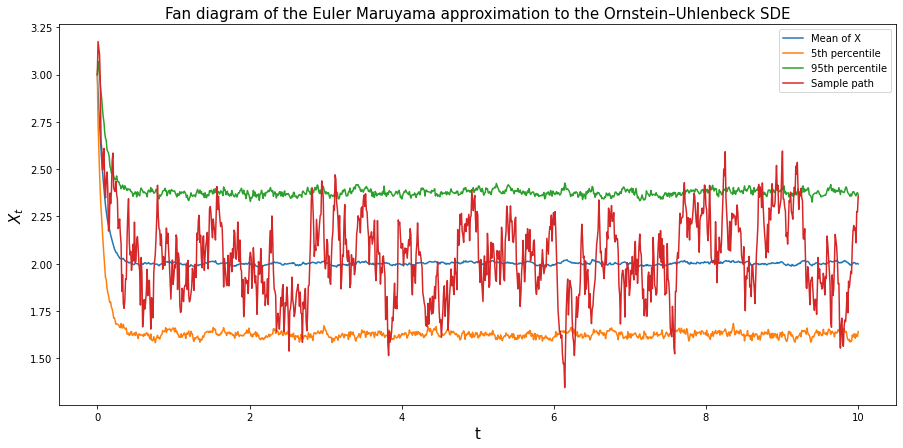

In [10]:
# This plot shows that for large theta, the mean reversion is quicker.
X0=3;theta=10;mu=2;sigma=1;
ornstein_uhlenbeck_fan_plot(X0, theta, mu, sigma)

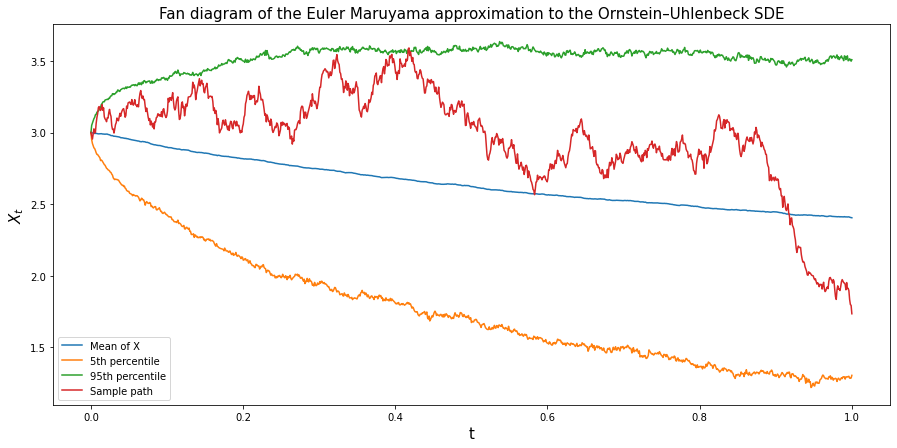

In [11]:
# For time interval [0,1]
X0=3;theta=1;mu=2;sigma=1;
ornstein_uhlenbeck_fan_plot(X0, theta, mu, sigma, T=1)

Previously, in the file `Geometric Brownian Motion.ipynb` we simulated $S_t$ using functions `simulate_gbm`or `simulate_gbm_paths`. There we used 
$$
\begin{split}
Z_0 &= \log(S_0) \\
Z_{(i+1)\delta t} &= Z_{(i)\delta t} + (\mu - \tfrac{1}{2} \sigma^2) \delta{t} + \sigma \sqrt{\delta{t}} \, \epsilon_{i \delta t} \\
S_{i\delta t}&=\exp(Z_{i \delta t})
\end{split}
$$

Suppose that we are interested in simulating the Euler-Maruyama
approximation to $S_t$ on a grid ${\cal T}=\{0,\delta t, 2 \delta t, \ldots \}$
where $S_t$ satisfies SDE
$$
d S_t = \mu S_t dt + \sigma S_t \, d W_t.
$$

Can we use the difference equation:
$$
S_{t+\delta t} = S_t + \mu S_t \delta t  + \sigma S_t \sqrt{\delta t} \, \epsilon_t
$$
where the $\epsilon_t$ are independent standard normal distributions and so avoid ever computing $W_t$ directly using Wiener's construction.
The answer is Yes.
By the properties of Brownian motion the increments $W_{t+\delta t}-W_t$ for points $t\in {\cal T}$ are independent
identically distributed normal random variables with variance $\delta t$. Hence we may simulate the values $W_{t-\delta t}-W_t$
using the values $\sqrt{\delta t} \, \epsilon_t$ in which case we will have that the Euler-Maruyama approximation is:
$$
S^{\cal T}_{t+\delta t} = S^{\cal T}_t + \mu S^{\cal T}_t \delta t  + \sigma S^{\cal T}_t \sqrt{\delta t} \, \epsilon_t.
$$

The point is that it is easy enough to simulate $S_t$ at points in a fixed grid ${\cal T}$ without ever needing to think
about Wiener's construction at all. What Wiener's construction allows us to do is refine the grid and prove convergence of the solution
as the grid becomes infinitely fine.

In [13]:
def simulate_gbm_eulermaruyama( S0, mu, sigma, T, n_steps, n_paths):
    """
    Simulate geometric Brownian motion paths using Euler-Maruyama Approximation. Returns a matrix of stock price
    paths. Each row in the matrix is a different path and each column represents a different time point like
    a plot: time goes horizontally, different paths are aligned vertically. Here we are √𝛿𝑡.𝜖 for 𝑊𝑡+𝛿𝑡−𝑊𝑡.
 
 
   
            Parameters:
                    S0 (double) : Initial Stock Price.
                    mu (double) :  Drift.
                    sigma (double) : Volatility.
                    T (double) : Length of time in years.
                    n_steps (int) : Number of time steps.
                    n_paths (int) : Number of Stock Price Paths to simulate.

            Returns:
                    S (double): Matrix of Stock Price Paths.
                    times (double) : Array of time points.
    
    """
    S = np.zeros( [ n_paths, n_steps+1] )  # Matrix of (n_paths X n_steps+1).
    dt = T/n_steps
    S[:,0] = np.log(S0)  # First column.
    times = np.linspace(0,T,n_steps+1)
    
    epsilon = np.random.randn( n_paths, n_steps )
    for i in range(0,n_steps):
        S[:,i+1] = S[:,i] + (S[:,i] * mu * dt) + (S[:,i] * sigma * np.sqrt(dt) * epsilon[:,i])  

    return S, times

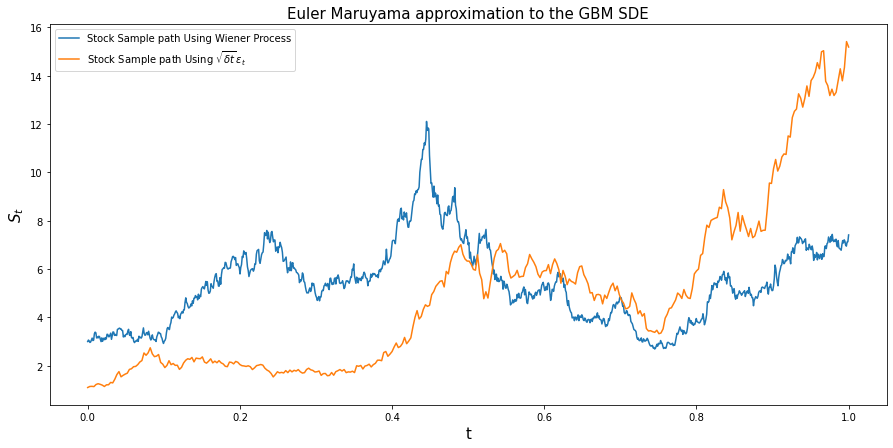

In [17]:
n_steps = 365 # Days in a year.
T = 1  # 1 year.

Se, times = simulate_gbm_eulermaruyama(S0,mu,sigma,T,n_steps,4000)

ax = plt.gca()
ax.plot(t, S[0,:],label='Stock Sample path Using Wiener Process')
ax.plot(times, Se[0,:],label='Stock Sample path Using $\sqrt{\delta t} \, \epsilon_t$')
plt.xlabel('t',fontsize = 15)
plt.ylabel('$S_t$',fontsize = 15)
plt.title('Euler Maruyama approximation to the GBM SDE', fontsize = 15)
ax.legend();